In [1]:
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
%matplotlib inline

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

In [3]:
def split_date(df):
    df = df.copy()
    df = df.rename(columns = {'Date': 'ds',
                            'Weekly_Sales': 'y'})
    df.ds =pd.to_datetime(df.ds,format='%Y-%m-%d')
    df['Year'] = pd.DatetimeIndex(df['ds']).year
    df['Month'] = pd.DatetimeIndex(df['ds']).month
    df['Day'] = pd.DatetimeIndex(df['ds']).day.astype('O')
    df['Store'] = df['Store'].astype('O')
    df['Dept'] = df['Dept'].astype('O')
    df.index = df['ds']
    df.drop(['ds'],axis=1,inplace=True)
    df['IsHoliday'].replace((True,False),(1,0),inplace=True)
    return df

In [4]:
df = split_date(train_df)


In [5]:
df

,Store,Dept,y,IsHoliday,Year,Month,Day
ds,,,,,,,
2010-02-05,1,1,24924.50,0,2010,2,5
2010-02-12,1,1,46039.49,1,2010,2,12
2010-02-19,1,1,41595.55,0,2010,2,19
2010-02-26,1,1,19403.54,0,2010,2,26
2010-03-05,1,1,21827.90,0,2010,3,5
2010-03-12,1,1,21043.39,0,2010,3,12
2010-03-19,1,1,22136.64,0,2010,3,19
2010-03-26,1,1,26229.21,0,2010,3,26
2010-04-02,1,1,57258.43,0,2010,4,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 421570 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
Store        421570 non-null object
Dept         421570 non-null object
y            421570 non-null float64
IsHoliday    421570 non-null int64
Year         421570 non-null int64
Month        421570 non-null int64
Day          421570 non-null object
dtypes: float64(1), int64(3), object(3)
memory usage: 25.7+ MB


In [7]:
df_mean = df.resample('W').mean()
df_mean

,y,IsHoliday,Year,Month
ds,,,,
2010-02-07,16836.121997,0,2010,2
2010-02-14,16352.056032,1,2010,2
2010-02-21,16216.658979,0,2010,2
2010-02-28,14899.549688,0,2010,2
2010-03-07,15921.015727,0,2010,3
2010-03-14,15546.850545,0,2010,3
2010-03-21,15286.773578,0,2010,3
2010-03-28,14975.894486,0,2010,3
2010-04-04,17098.620298,0,2010,4


In [8]:
def test_stationarity(x):
    
    #Determing rolling statistics
    rolmean = x.rolling(window=2, center=False).mean()
    rolstd = x.rolling(window=2, center=False).std()

    #Plot rolling statistics:
    plt.figure (figsize=(17, 12))
    orig = plt.plot(x, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid()
    plt.xticks(rotation=90)
    plt.locator_params(nbins=60, axis = 'x')
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    tstest = adfuller(x['y'], autolag='AIC')
    tsoutput = pd.Series(tstest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in tstest[4].items():
        tsoutput['Critical Value (%s)' % key] = value
    print(tsoutput)

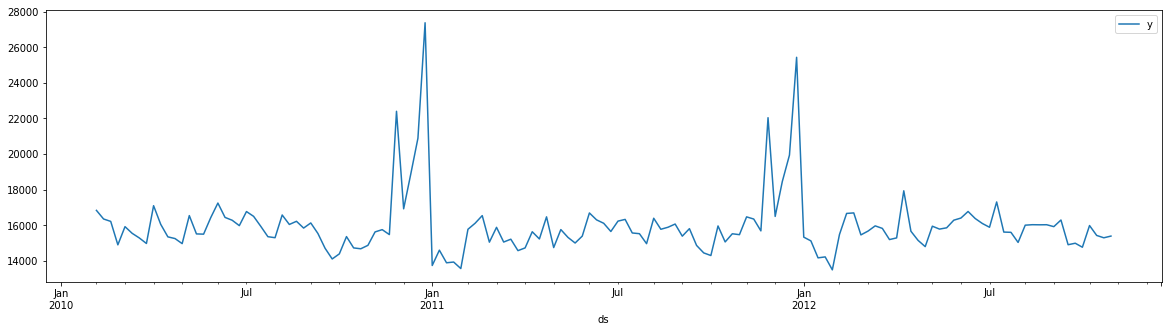

In [9]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 1, 1)
df_mean[['y']].plot(ax=ax)
plt.show()


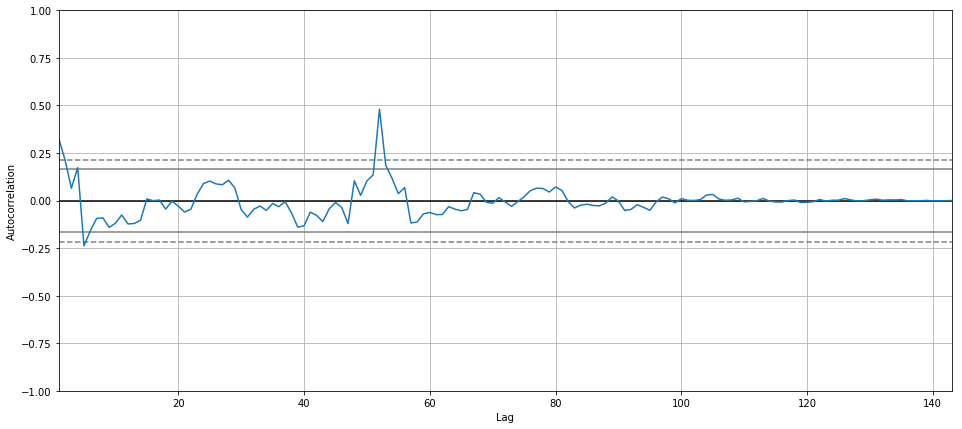

In [10]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(16, 7))
autocorrelation_plot(df_mean['y'])

/home/test/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1449: UserWarning: 'set_params()' not defined for locator of type <class 'pandas.plotting._converter.PandasAutoDateLocator'>
  str(type(self)))


Results of Dickey-Fuller Test:
Test Statistic                -5.930803e+00
p-value                        2.383227e-07
#Lags Used                     4.000000e+00
Number of Observations Used    1.380000e+02
Critical Value (1%)           -3.478648e+00
Critical Value (5%)           -2.882722e+00
Critical Value (10%)          -2.578065e+00
dtype: float64


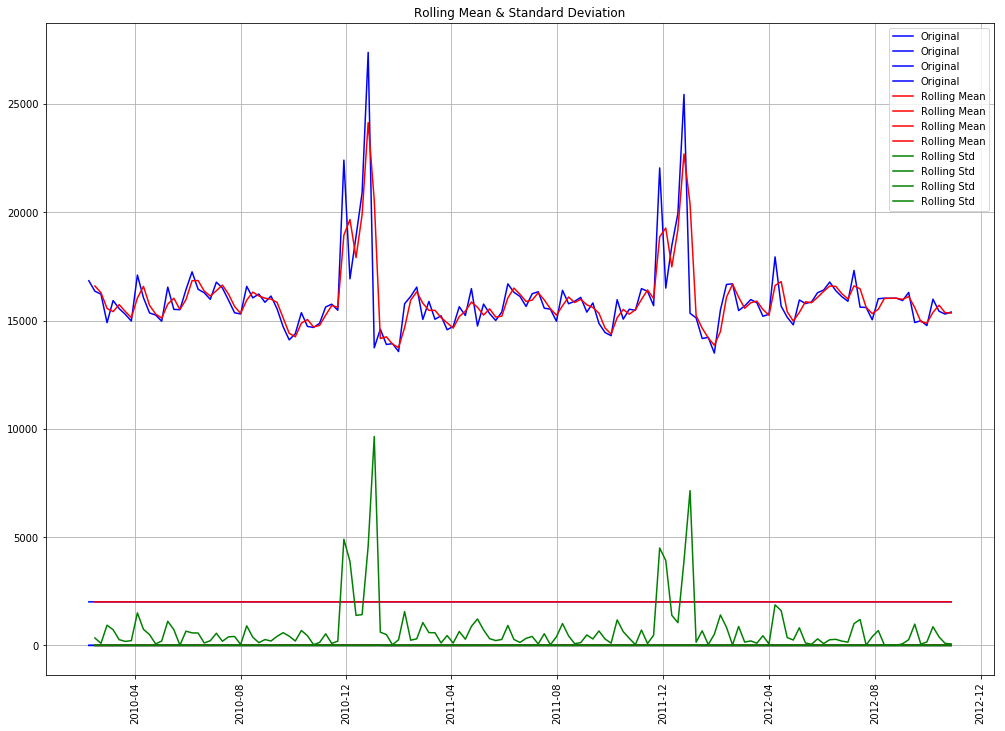

In [11]:
from  statsmodels.tsa.stattools import adfuller
test_stationarity(df_mean)

/home/test/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  after removing the cwd from sys.path.


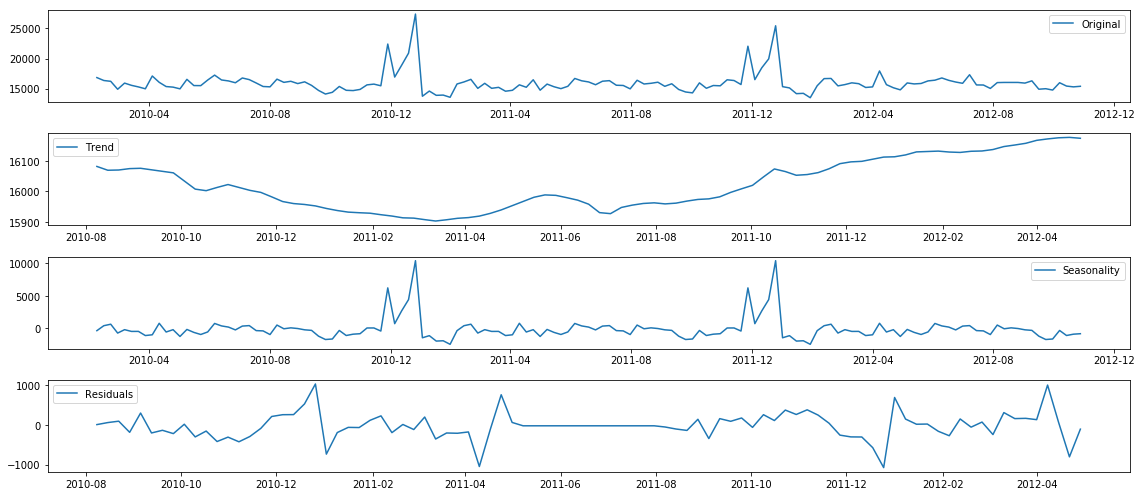

In [12]:
decompose =  df_mean['y']

from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.core import datetools
decomposition = seasonal_decompose(decompose)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(16, 7))
plt.subplot(411)
plt.plot(df_mean['y'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

/home/test/miniconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


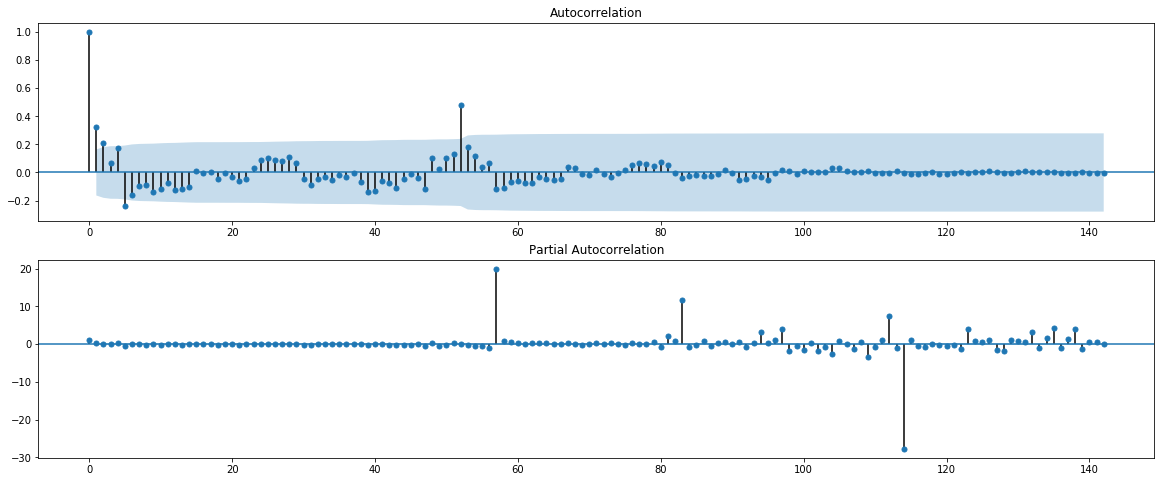

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
series = pd.Series(df_mean['y'])
plt.figure(figsize=(20,8))
plt.subplot(211)
plot_acf(series, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, ax=plt.gca())
plt.show()

In [14]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
Super_Bowl = pd.to_datetime(('12-Feb-10', '11-Feb-11', '10-Feb-12', '8-Feb-13'))
Super_Bowl.strftime('%Y-%m-%d')
Labor_Day =  pd.to_datetime(('10-Sep-10', '9-Sep-11', '7-Sep-12', '6-Sep-13'))
Labor_Day.strftime('%Y-%m-%d')
Thanksgiving =  pd.to_datetime(('26-Nov-10', '25-Nov-11', '23-Nov-12', '29-Nov-13'))
Thanksgiving.strftime('%Y-%m-%d')
Christmas =  pd.to_datetime(('31-Dec-10', '30-Dec-11', '28-Dec-12', '27-Dec-13'))
Christmas.strftime('%Y-%m-%d')

array(['2010-12-31', '2011-12-30', '2012-12-28', '2013-12-27'],
      dtype='<U10')

In [16]:
Super_Bowl = pd.DataFrame({'holiday': 'Super_Bowl',
                      'ds': pd.to_datetime(Super_Bowl)})
Labor_Day = pd.DataFrame({'holiday': 'Labor_Day',
                      'ds': pd.to_datetime(Labor_Day)})
Thanksgiving = pd.DataFrame({'holiday': 'Thanksgiving',
                      'ds': pd.to_datetime(Thanksgiving)})
Christmas = pd.DataFrame({'holiday': 'Christmas',
                      'ds': pd.to_datetime(Christmas)})


In [17]:
holidays = pd.concat((Super_Bowl, Labor_Day, Thanksgiving, Christmas)).reset_index()     
holidays

,index,ds,holiday
0,0,2010-02-12,Super_Bowl
1,1,2011-02-11,Super_Bowl
2,2,2012-02-10,Super_Bowl
3,3,2013-02-08,Super_Bowl
4,0,2010-09-10,Labor_Day
5,1,2011-09-09,Labor_Day
6,2,2012-09-07,Labor_Day
7,3,2013-09-06,Labor_Day
8,0,2010-11-26,Thanksgiving
9,1,2011-11-25,Thanksgiving


In [36]:
# f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))
for store in df.Store.sort_values().unique():
    for dept in df.Dept.sort_values().unique():
        resample = df[df.Dept==dept].resample('W-FRI')['y'].mean().dropna()
        new_df = pd.DataFrame(resample).reset_index()
        print(store,dept)
#         print(new_df)
        my_model = Prophet(interval_width = 0.95, holidays = holidays)
        my_model.fit(new_df)
        future_dates = my_model.make_future_dataframe(periods = 39,freq='W-FRI')
        print("First week to forecast.")
        print(future_dates)
        forecast = my_model.predict(future_dates)
        break
    break

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


1 1
First week to forecast.
            ds
0   2010-02-05
1   2010-02-12
2   2010-02-19
3   2010-02-26
4   2010-03-05
5   2010-03-12
6   2010-03-19
7   2010-03-26
8   2010-04-02
9   2010-04-09
10  2010-04-16
11  2010-04-23
12  2010-04-30
13  2010-05-07
14  2010-05-14
15  2010-05-21
16  2010-05-28
17  2010-06-04
18  2010-06-11
19  2010-06-18
20  2010-06-25
21  2010-07-02
22  2010-07-09
23  2010-07-16
24  2010-07-23
25  2010-07-30
26  2010-08-06
27  2010-08-13
28  2010-08-20
29  2010-08-27
..         ...
152 2013-01-04
153 2013-01-11
154 2013-01-18
155 2013-01-25
156 2013-02-01
157 2013-02-08
158 2013-02-15
159 2013-02-22
160 2013-03-01
161 2013-03-08
162 2013-03-15
163 2013-03-22
164 2013-03-29
165 2013-04-05
166 2013-04-12
167 2013-04-19
168 2013-04-26
169 2013-05-03
170 2013-05-10
171 2013-05-17
172 2013-05-24
173 2013-05-31
174 2013-06-07
175 2013-06-14
176 2013-06-21
177 2013-06-28
178 2013-07-05
179 2013-07-12
180 2013-07-19
181 2013-07-26

[182 rows x 1 columns]


/home/test/miniconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [41]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2010-02-05,22390.994201,12181.817742,32526.872030
1,2010-02-12,28311.765927,18429.464451,38393.727632
2,2010-02-19,24665.177895,13622.781287,34786.267939
3,2010-02-26,20234.171591,9992.774723,30332.316502
4,2010-03-05,15235.663090,4126.494035,25260.108933
5,2010-03-12,13668.591146,2882.480388,23719.823737
6,2010-03-19,17657.394309,7032.256673,26861.258362
7,2010-03-26,25270.011346,14972.510596,35116.164845
8,2010-04-02,31611.070835,21053.226365,42385.322331
9,2010-04-09,32660.174739,22786.709124,43374.431510


In [38]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

In [39]:
fc

,ds,yhat
0,2010-02-05,22390.994201
1,2010-02-12,28311.765927
2,2010-02-19,24665.177895
3,2010-02-26,20234.171591
4,2010-03-05,15235.663090
5,2010-03-12,13668.591146
6,2010-03-19,17657.394309
7,2010-03-26,25270.011346
8,2010-04-02,31611.070835
9,2010-04-09,32660.174739


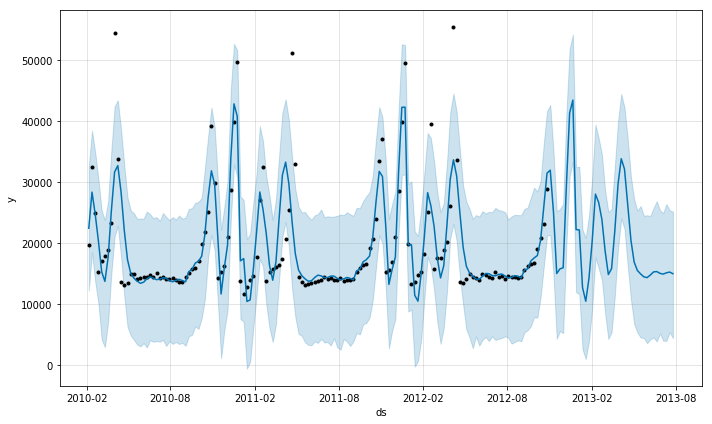

In [40]:
my_model.plot(forecast);

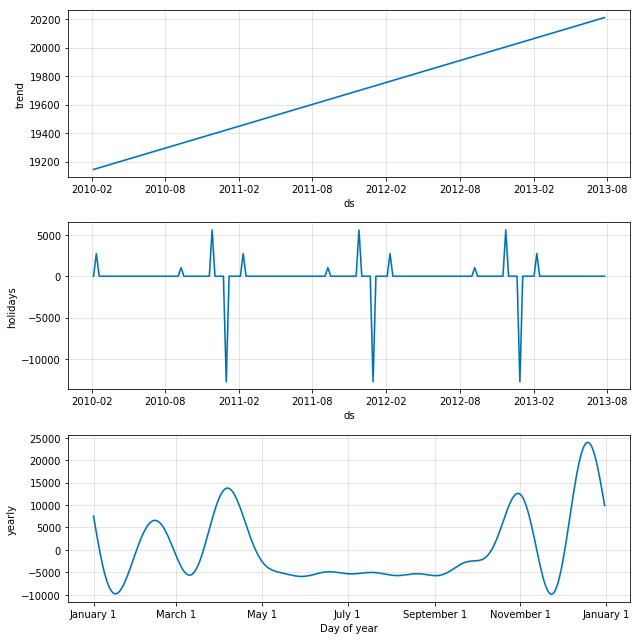

In [42]:
my_model.plot_components(forecast);